# Forecast interpretation notebook

This notebook contains examples of forecast decomposition into additive components for various models.

**Table of contents**
* [Forecast decomposition](#chapter1)
    * [CatBoost](#chapter1_1)
    * [SARIMAX](#chapter1_2)
    * [BATS](#chapter1_3)
* [Accessing target components](#chapter2)
* [Components relevance](#chapter3)

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
from copy import deepcopy
import pandas as pd

from etna.analysis import plot_backtest
from etna.analysis import plot_forecast_decomposition
from etna.datasets import TSDataset
from etna.pipeline import Pipeline
from etna.transforms import LagTransform
from etna.metrics import MAE

In [3]:
HORIZON = 20

Consider the dataset `data/example_dataset.csv`.

We will use this data to demonstrate how model forecasts can be decomposed down to individual effects in ETNA library.

Let's load and plot this data to get a brief idea of how time series look.

In [4]:
df = pd.read_csv("data/example_dataset.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = TSDataset.to_dataset(df)
ts = TSDataset(df, freq="D")

ts.head(5)

segment    segment_a segment_b segment_c segment_d
feature       target    target    target    target
timestamp                                         
2019-01-01       170       102        92       238
2019-01-02       243       123       107       358
2019-01-03       267       130       103       366
2019-01-04       287       138       103       385
2019-01-05       279       137       104       384

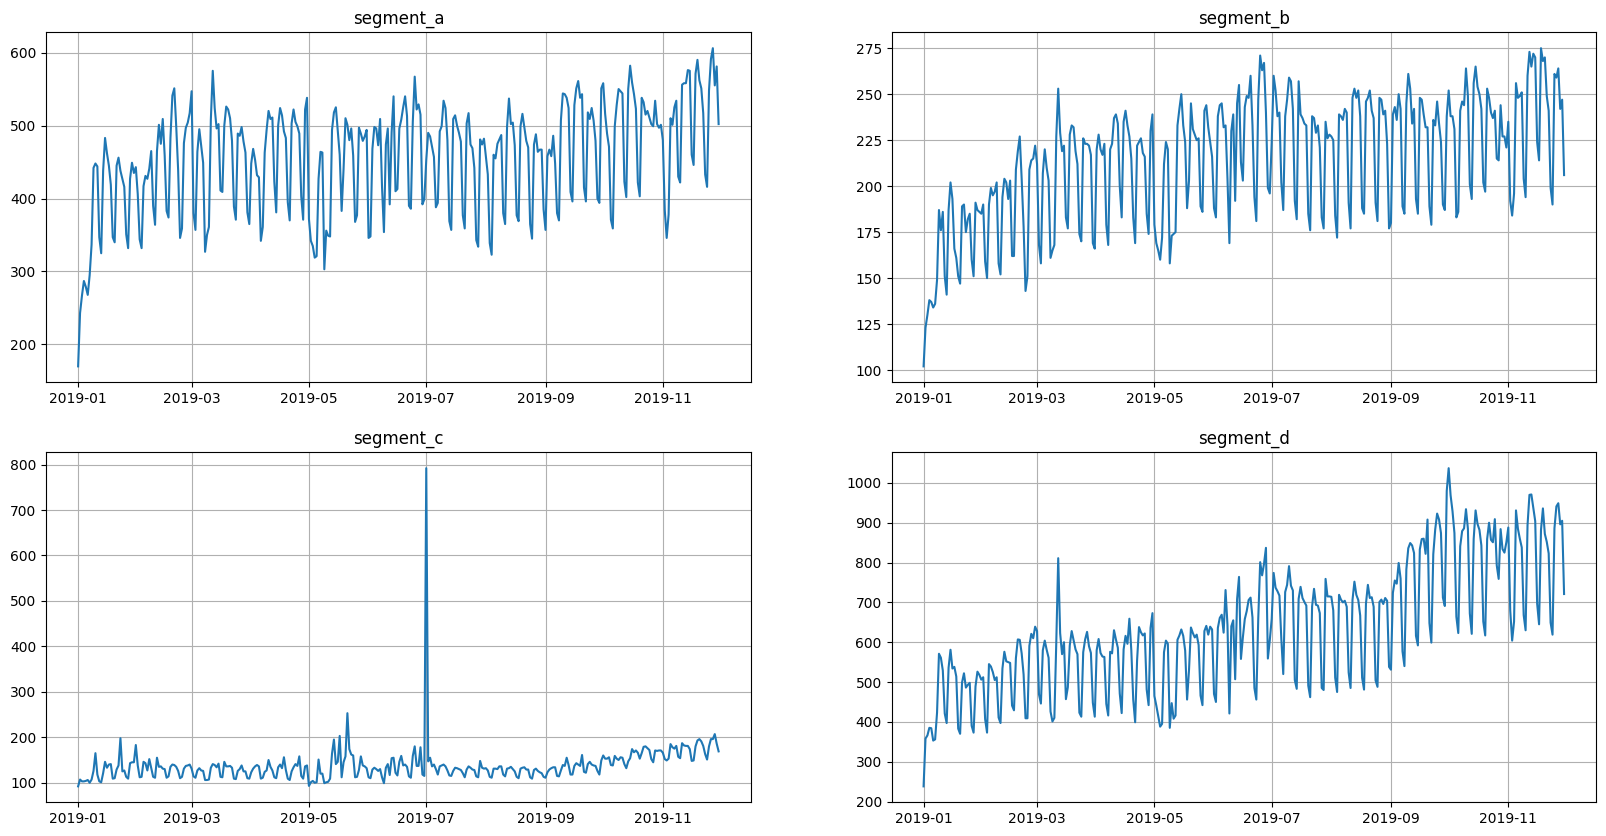

In [5]:
ts.plot()

Here we have four segments in the dataset. All segments have seasonalities, and some of them show signs of trend.

Some of the models need features in order to estimate forecasts. Here we will use lags of the target variable as
features when it is necessary.

In [6]:
transforms = [
    LagTransform(in_column="target", lags=list(range(21, 57, 7)), out_column="lag"),
]

## 1. Forecast decomposition <a class="anchor" id="chapter1"></a>

This section shows how a model forecast can be decomposed down to individual additive components.
There are two types of decomposition:
* model-specific decomposition
* model-agnostic decomposition

**Model-specific** decomposition uses model representation to compute components. Consider linear regression as an example.
$\hat y = w^T X + b$. We can slightly rewrite this equation to see additive components $\hat y = \sum_{i=0}^m w_i x_i + b$.
So in this case, the components are: $w_i x_i$ and $b$.

**Model-agnostic** decomposition uses separate estimators to compute the contribution of each component (e.g., SHAP).

The main feature of forecast decomposition in the ETNA library is guaranteed additive components.

There several models with available decomposition:
* `SARIMAXModel`
* `AutoARIMAModel`
* `CatBoostPerSegmentModel`, `CatBoostMultiSegmentModel`
* `SimpleExpSmoothingModel`, `HoltModel`, `HoltWintersModel`
* `LinearPerSegmentModel`, `ElasticPerSegmentModel`, `LinearMultiSegmentModel`, `ElasticMultiSegmentModel`
* `ProphetModel`
* `MovingAverageModel`, `NaiveModel`, `DeadlineMovingAverageModel`, `SeasonalMovingAverageModel`
* `BATS`, `TBATS`

In this notebook, we will take a closer look at the forecast decomposition for `CatBoost`, `SARIMAX` and `BATS`.

## 1.1 CatBoost <a class="anchor" id="chapter1_1"></a>
CatBoost uses model-agnostic forecast decomposition. Components contributions estimated with SHAP for each timestamp.
Decomposition at timestamp $t$ could be represented as:

\begin{equation}
f(x_t) = \phi_0 + \sum_{i = 1}^m \phi_i
\end{equation}

Where $\phi_i$ - SHAP values.

In [7]:
from etna.models import CatBoostPerSegmentModel
from etna.models import CatBoostMultiSegmentModel

Here we create `Pipeline` with `CatBoostPerSegmentModel` and estimate forecast components.

In [8]:
pipeline = Pipeline(model=CatBoostPerSegmentModel(), transforms=transforms, horizon=HORIZON)

_, forecast_df, _ = pipeline.backtest(ts=ts, metrics=[MAE()], n_folds=3, forecast_params={"return_components": True})

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0

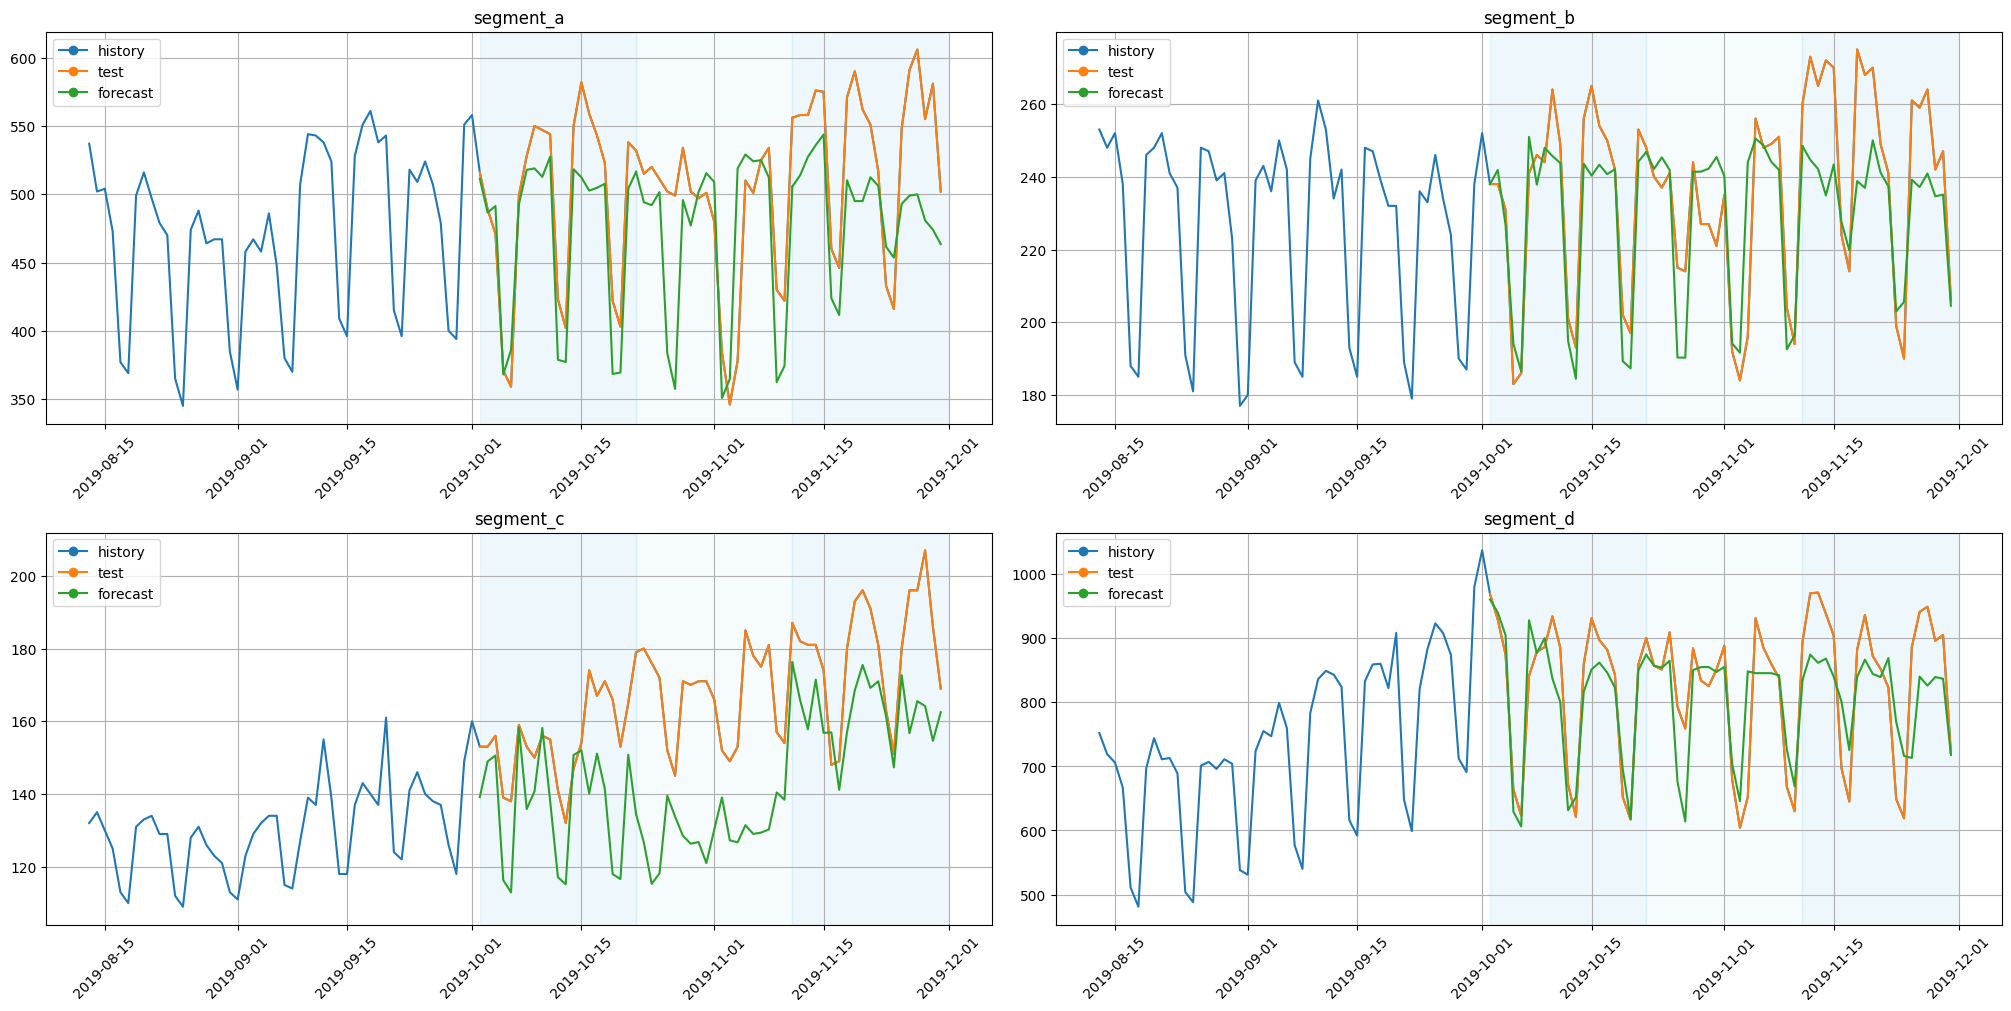

In [9]:
plot_backtest(forecast_df=forecast_df, ts=ts, history_len=50)

Components could be plotted with the function `plot_forecast_decomposition`.

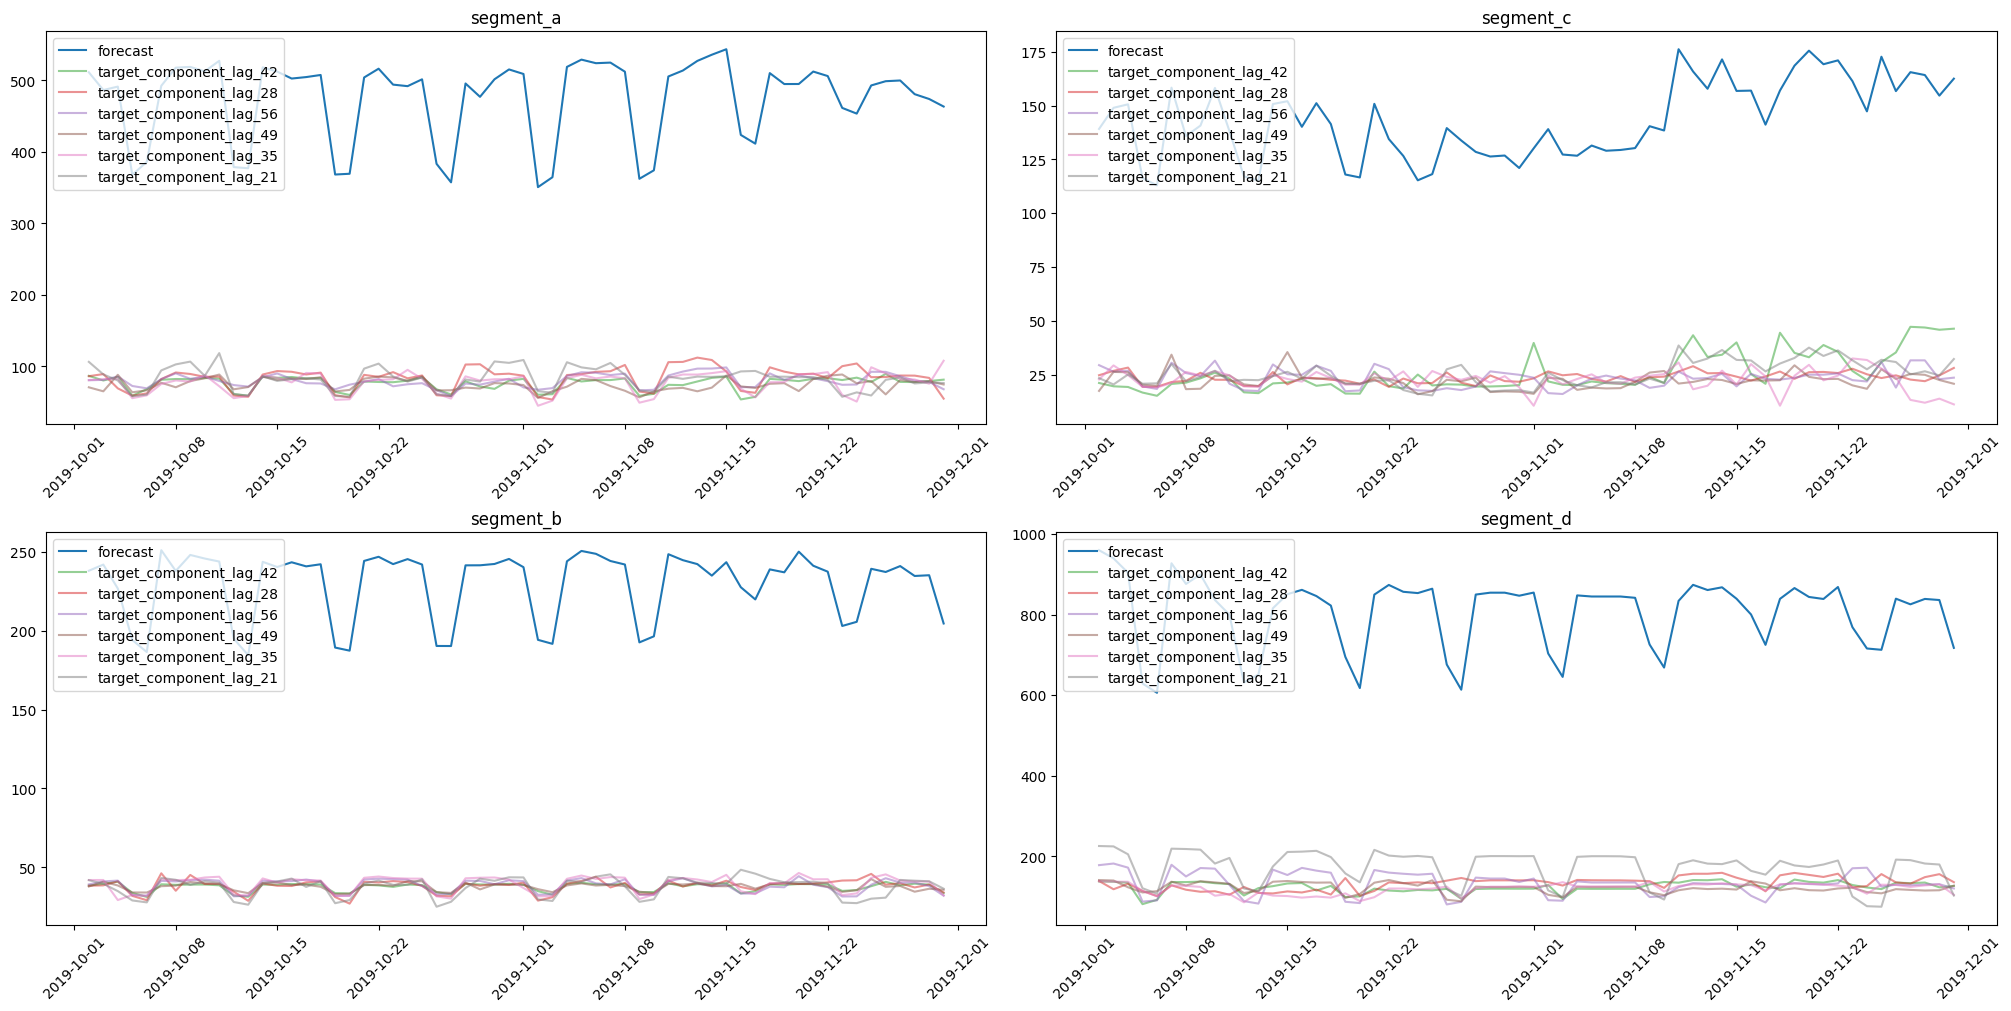

In [10]:
plot_forecast_decomposition(forecast_ts=TSDataset(df=forecast_df, freq="D"), mode="joint", columns_num=2)

On these charts we can see how each feature contributed to the forecast for each timestamp.
CatBoost uses features to estimate forecasts, so each forecast component corresponds to a particular feature.

Let's run a similar procedure for `CatBoostMultiSegmentModel`.

In [11]:
pipeline = Pipeline(model=CatBoostMultiSegmentModel(), transforms=transforms, horizon=HORIZON)

_, forecast_df, _ = pipeline.backtest(ts=ts, metrics=[MAE()], n_folds=3, forecast_params={"return_components": True})

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0

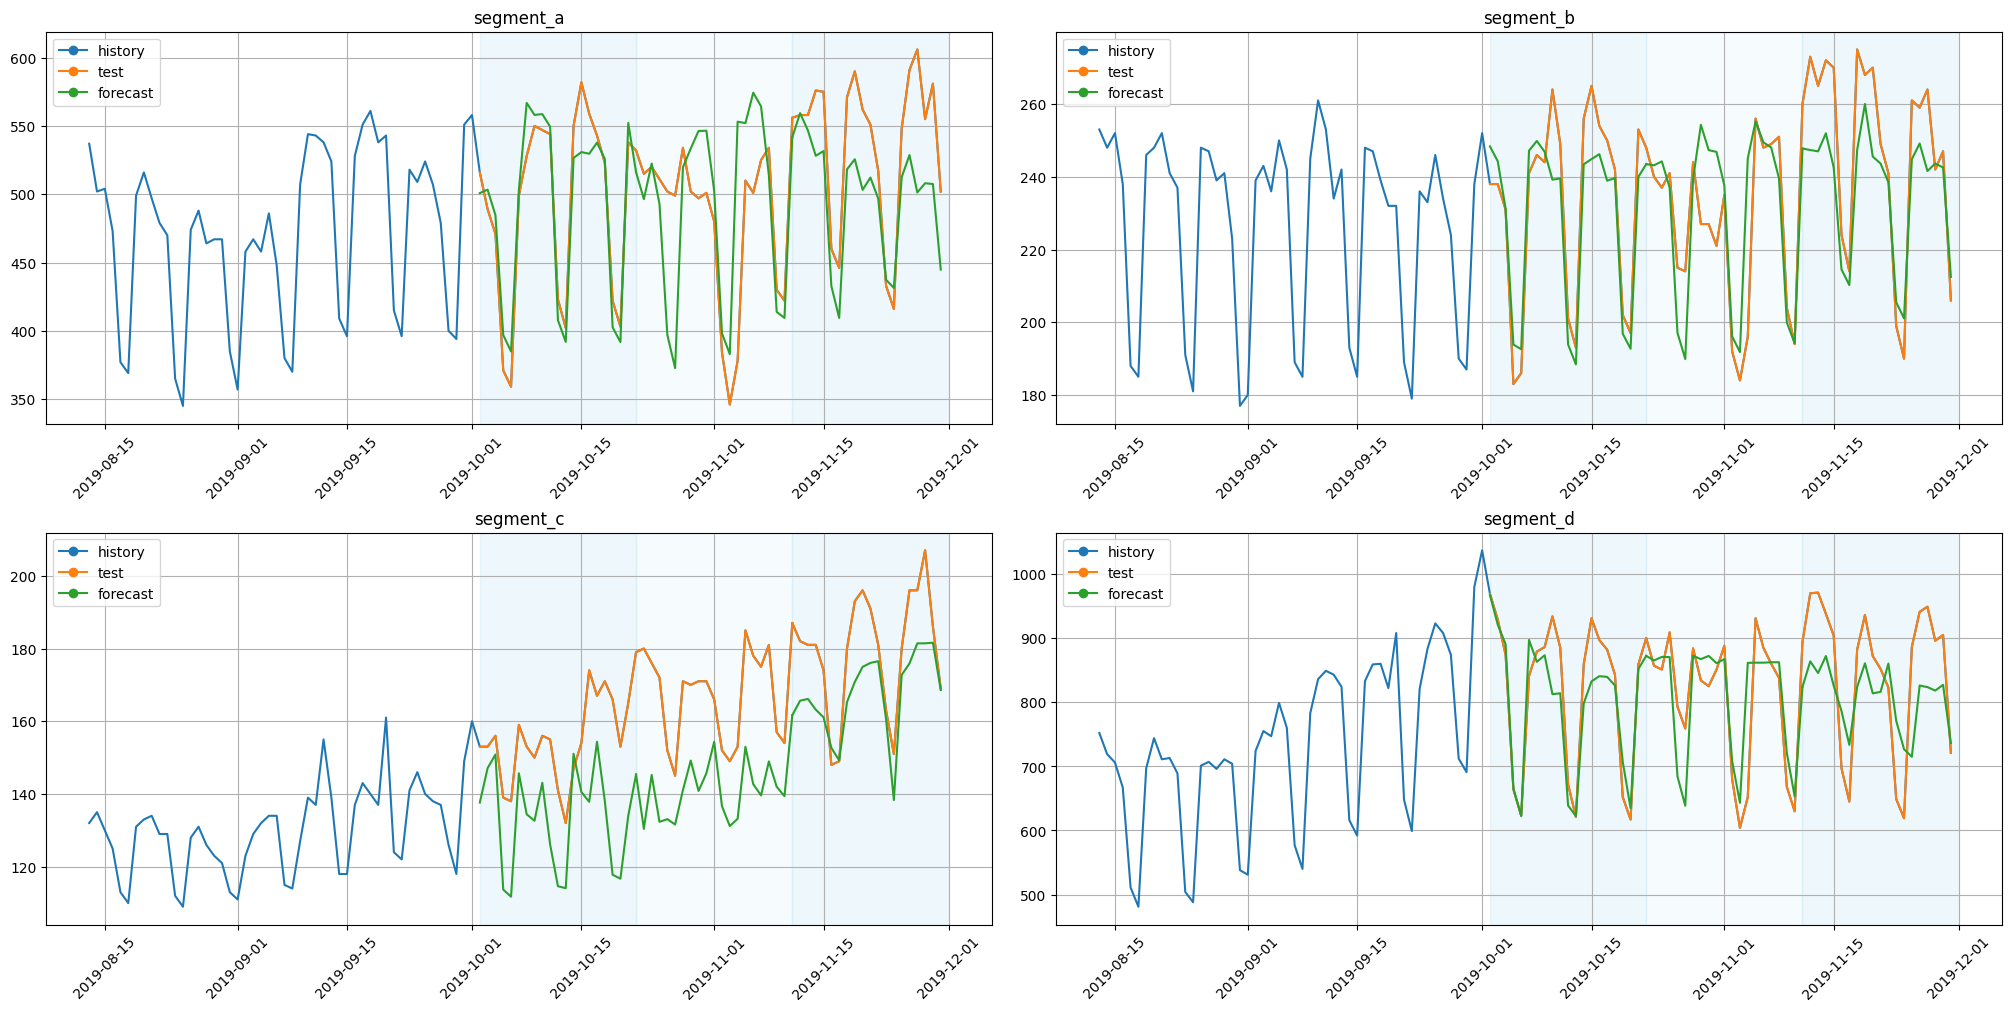

In [12]:
plot_backtest(forecast_df=forecast_df, ts=ts, history_len=50)

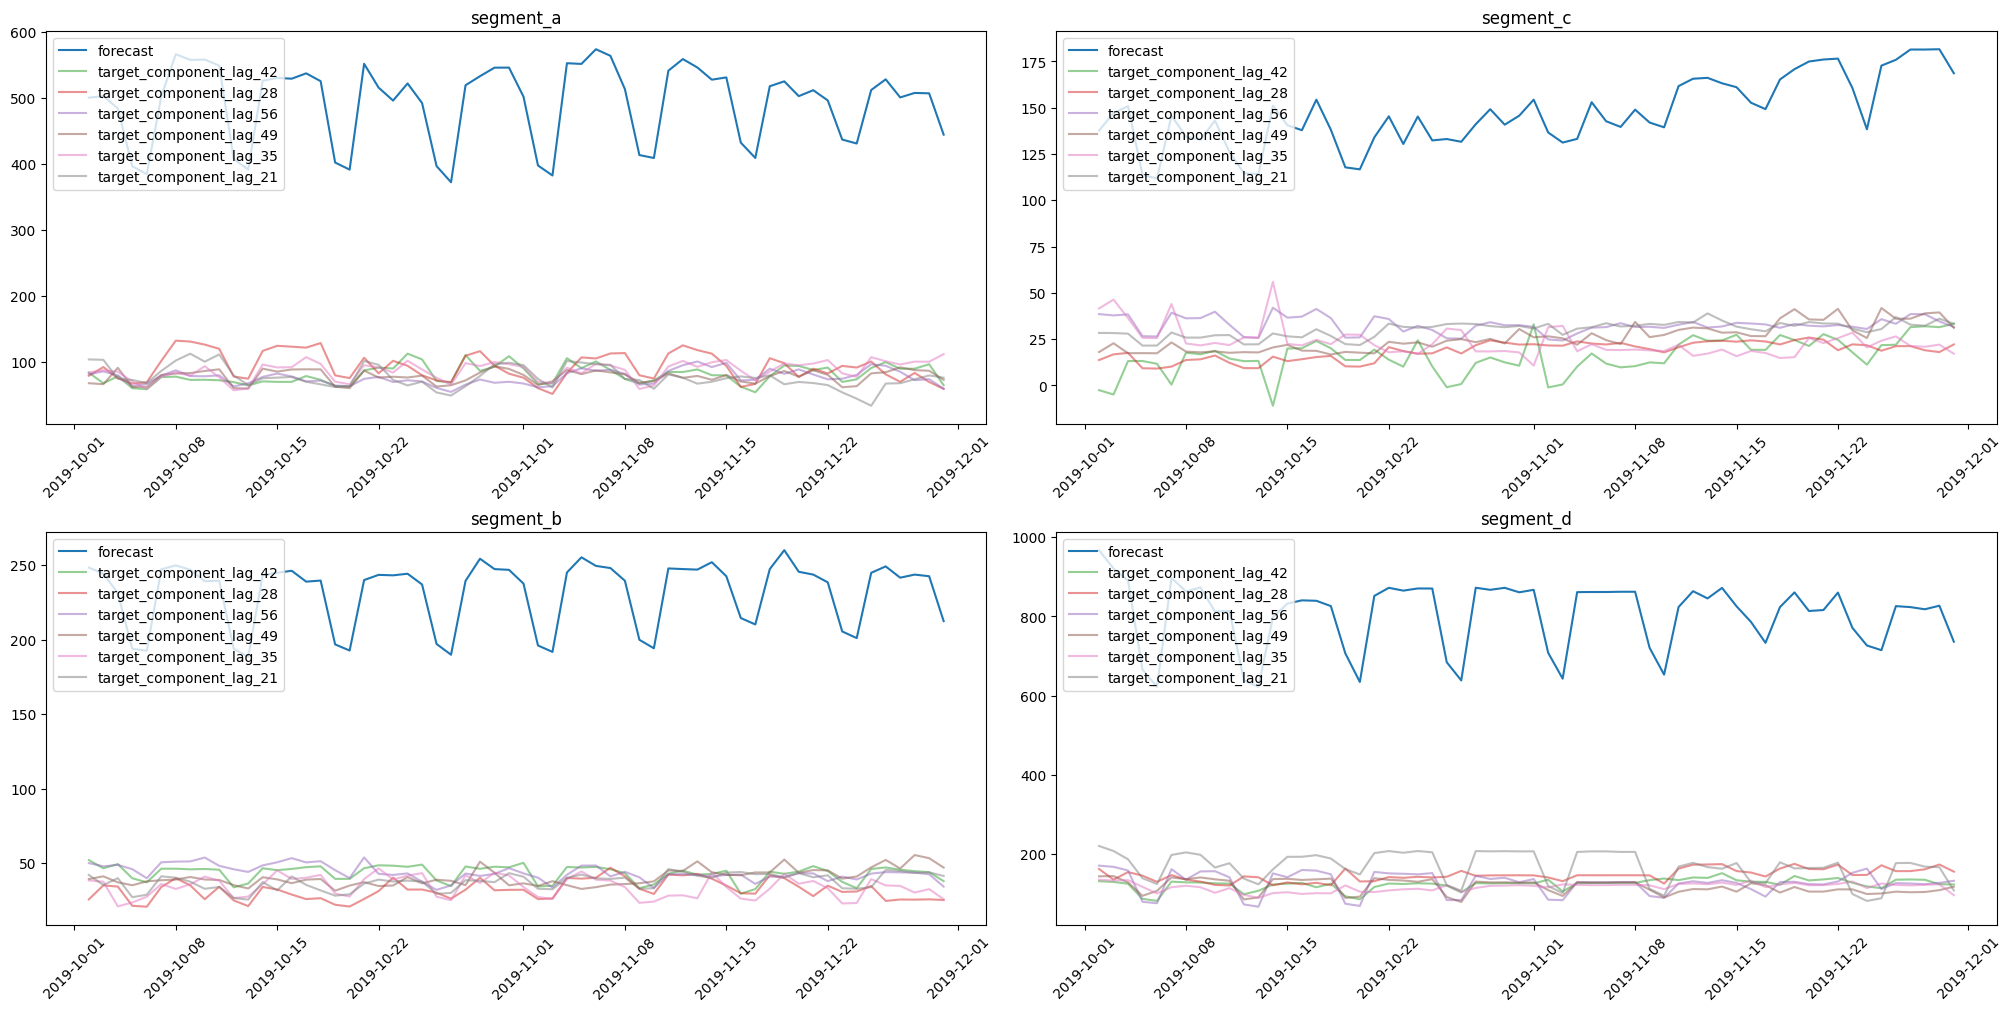

In [13]:
plot_forecast_decomposition(forecast_ts=TSDataset(df=forecast_df, freq="D"), mode="joint", columns_num=2)

Here we obtained almost similar results. They are identical in structure but slightly different when comparing values.
Such behaviour is explained by the use of a single model for all dataset segments.

## 1.2 SARIMAX <a class="anchor" id="chapter1_2"></a>
SARIMAX uses model-specific forecast decomposition. So the main components of this model are: SARIMA
and effects from exogenous variables.

Such constraints on decomposition form are due to implementation details of SARIMAX models,
which are estimated as state-space models.

In [14]:
from etna.models import SARIMAXModel

Let's build `Pipeline` with `SARIMAXModel` and estimate forecast components on backtest.

In [15]:
pipeline = Pipeline(model=SARIMAXModel(), transforms=transforms, horizon=HORIZON)

_, forecast_df, _ = pipeline.backtest(ts=ts, metrics=[MAE()], n_folds=3, forecast_params={"return_components": True})

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0

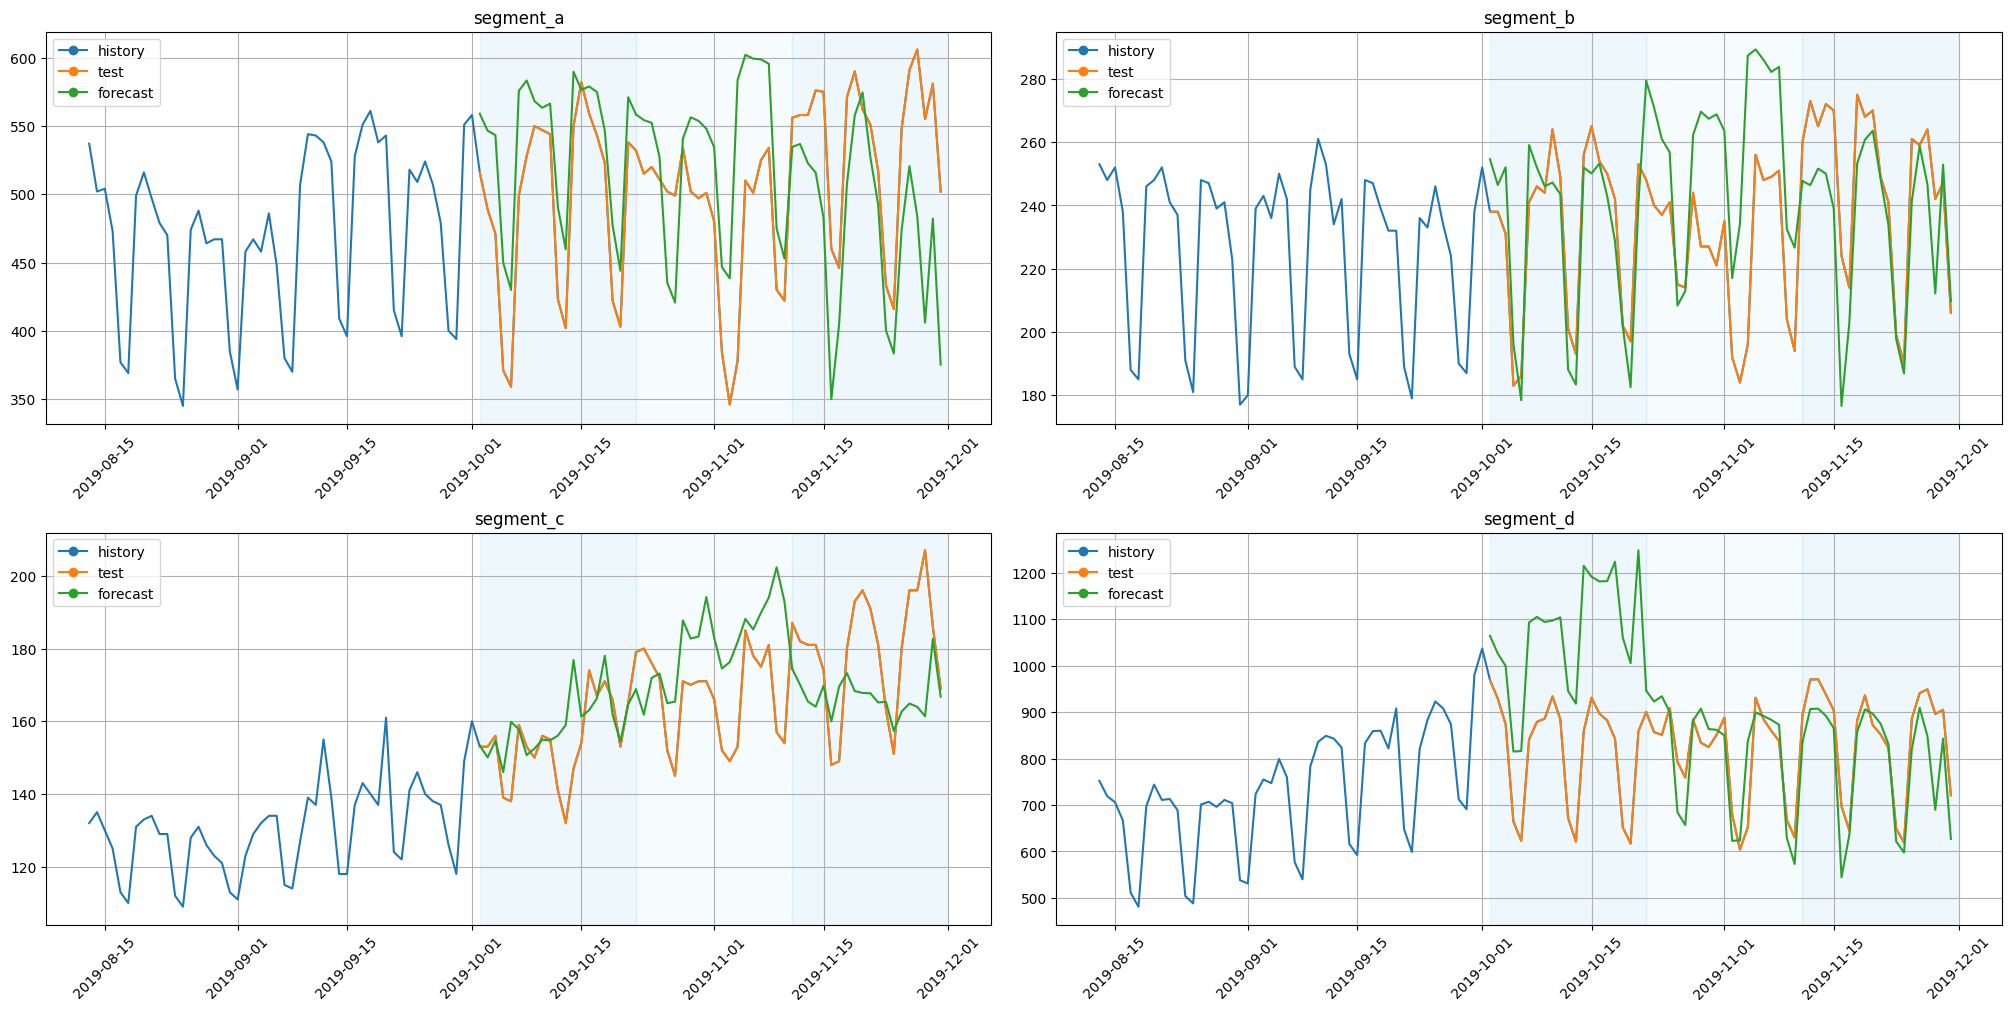

In [16]:
plot_backtest(forecast_df=forecast_df, ts=ts, history_len=50)

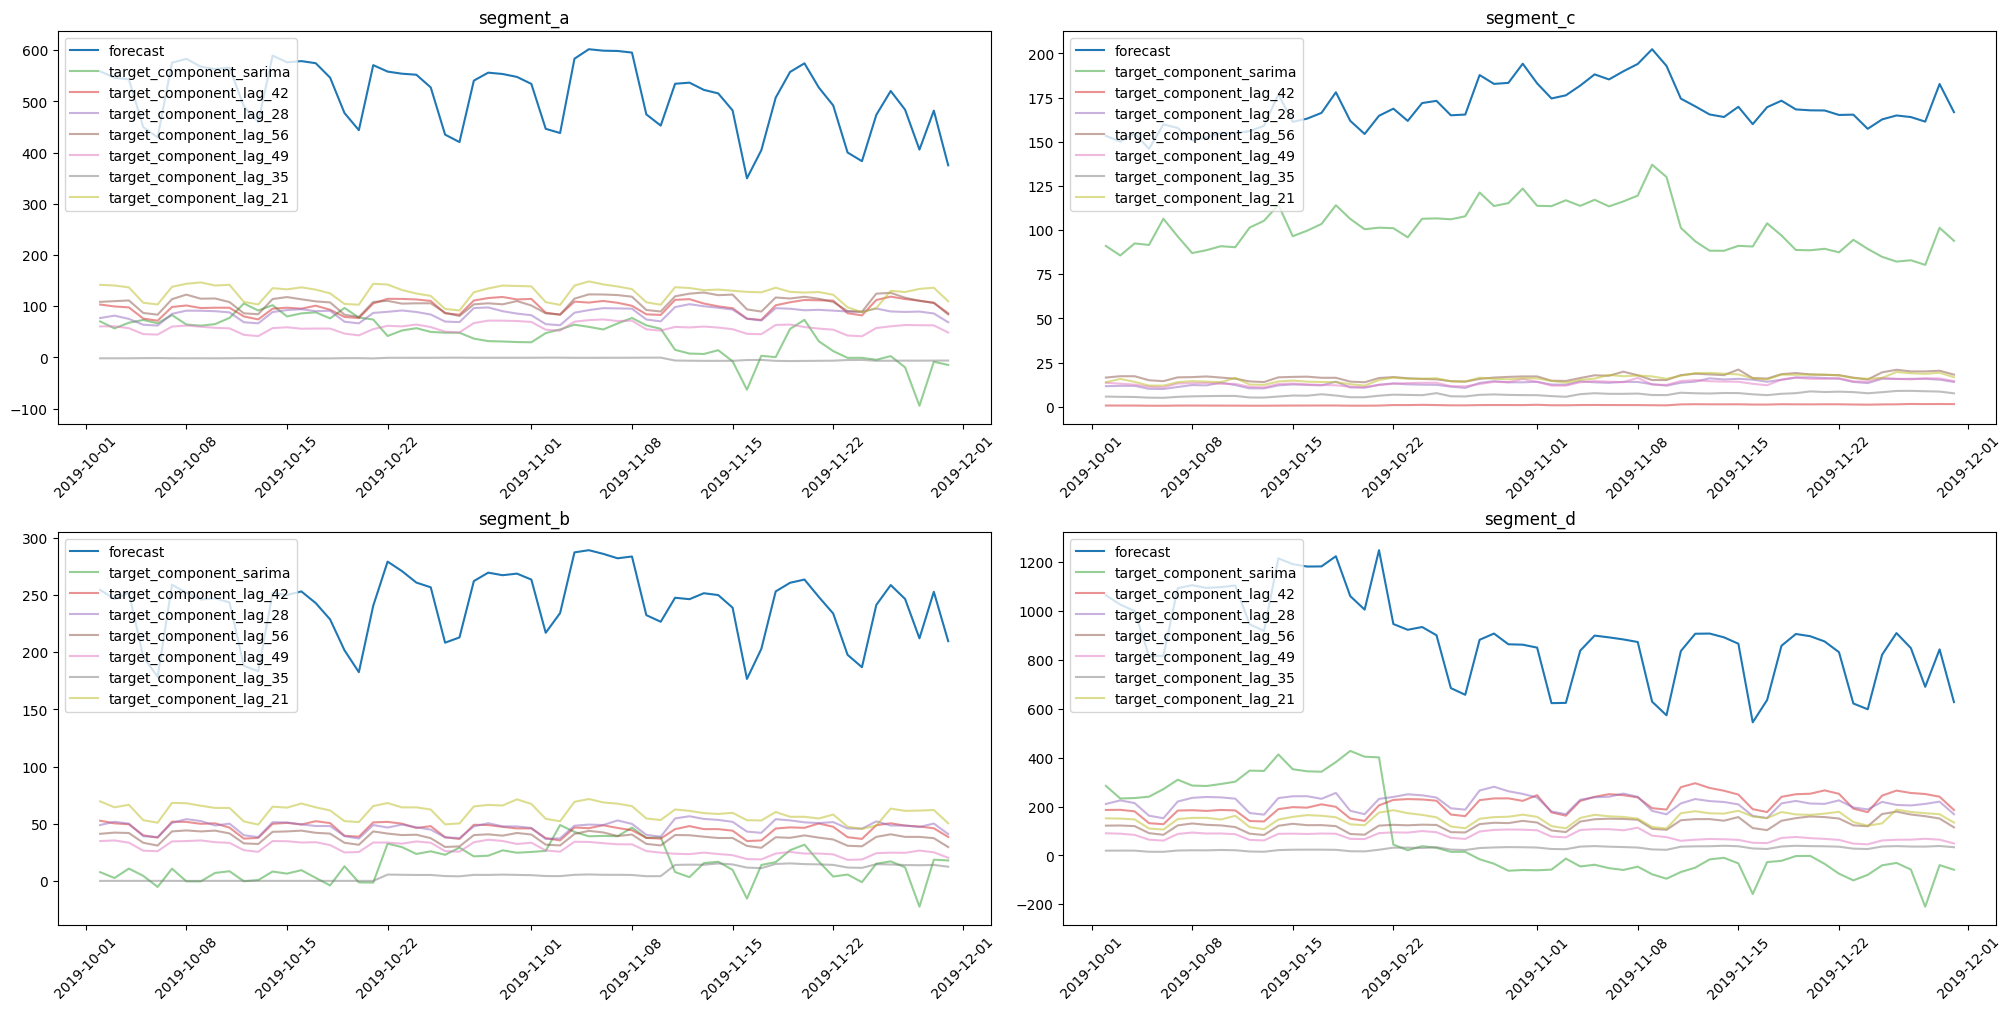

In [17]:
plot_forecast_decomposition(forecast_ts=TSDataset(df=forecast_df, freq="D"), mode="joint", columns_num=2)

Here we can notice components for each exogenous variable and a separate component for the SARIMA effect.
Note that this decomposition is completely different from the forecast decomposition of CatBoost models,
even on the same data. This is due to different approaches for component contribution estimation.

## 1.3 BATS <a class="anchor" id="chapter1_3"></a>
BATS uses model-specific forecast decomposition. The main components are:
* trend
* local level
* seasonality for each specified period
* errors ARMA(p, q)

The last two components are controlled by `seasonal_periods` and `use_arma_erros` parameters, respectively.
The trend component is controlled by `use_trend`. These parameters add flexibility to the model representation and,
hence, to the forecast decomposition.

In [18]:
from etna.models import BATSModel

Let's build `Pipeline` and estimate forecast decomposition with `BATSModel`, but now without any features.

In [19]:
pipeline = Pipeline(model=BATSModel(seasonal_periods=[14, 21]), horizon=HORIZON)

_, forecast_df, _ = pipeline.backtest(ts=ts, metrics=[MAE()], n_folds=3, forecast_params={"return_components": True})

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0

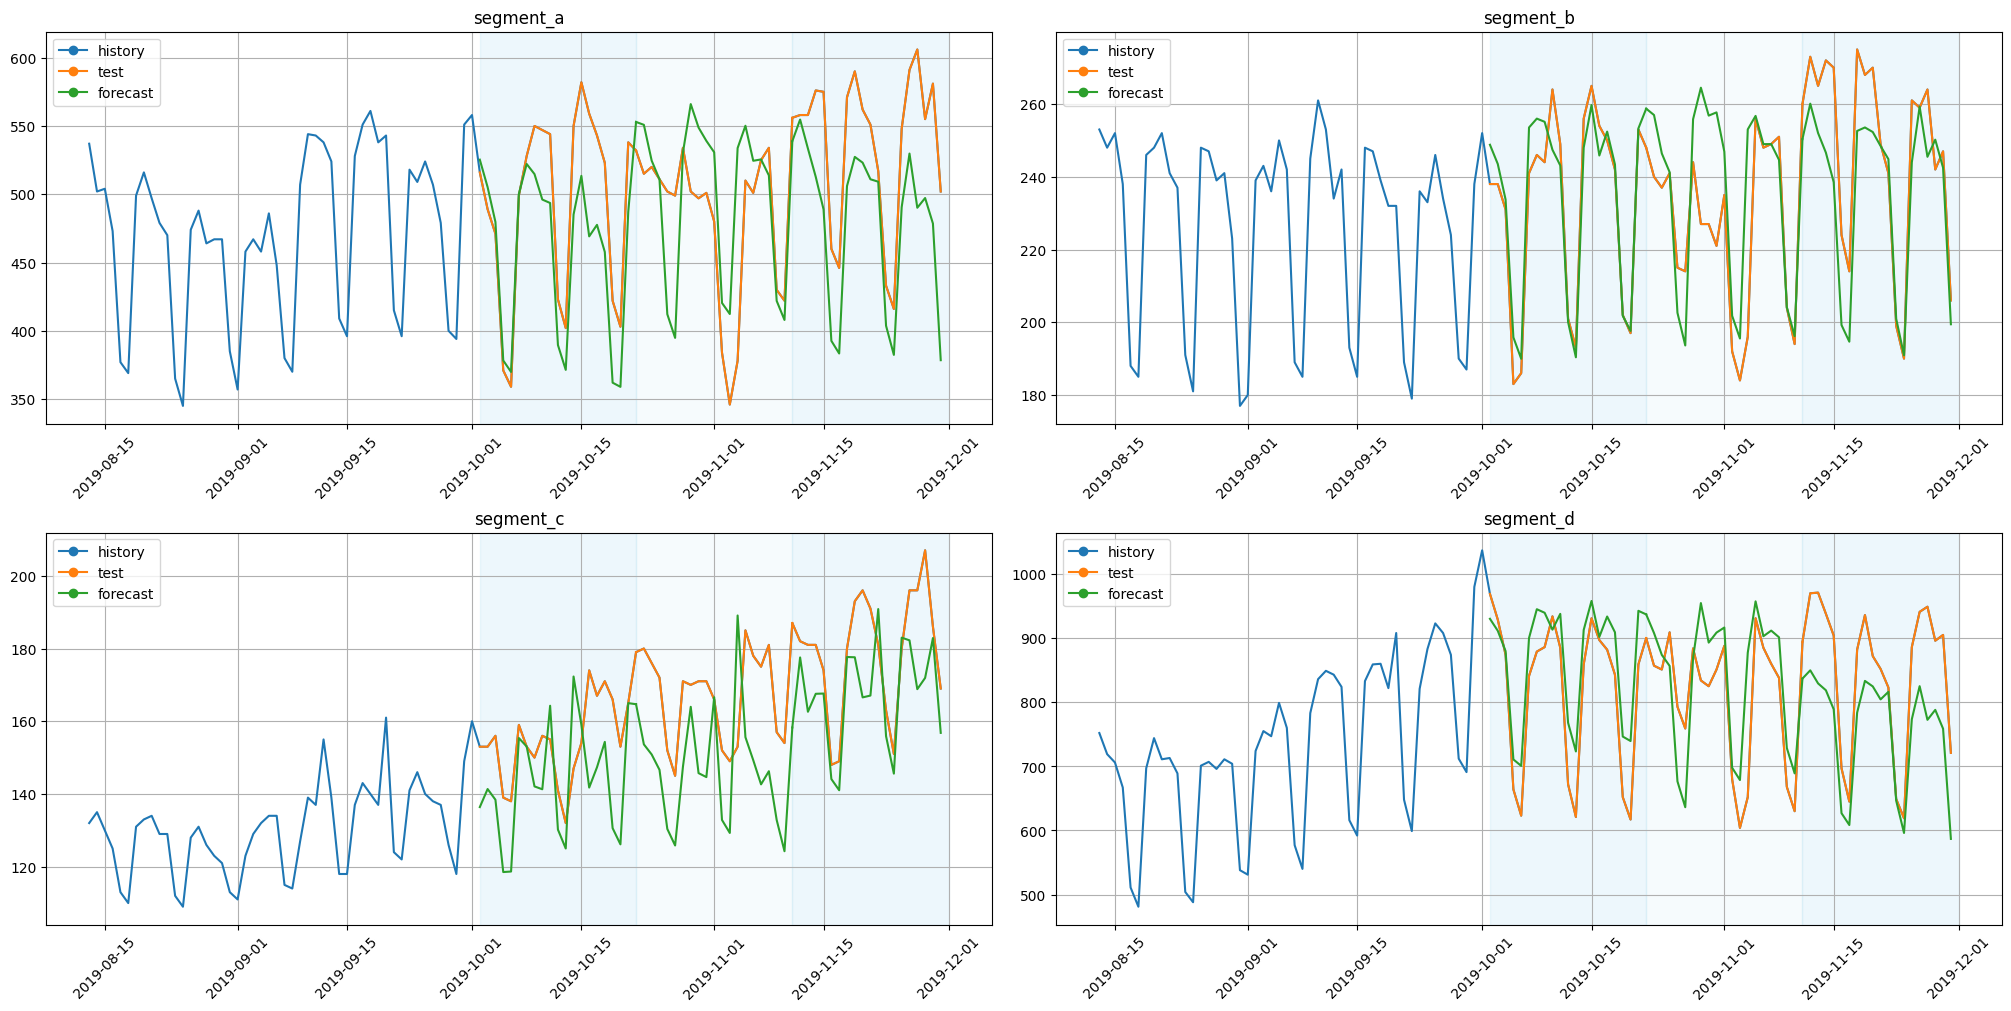

In [20]:
plot_backtest(forecast_df=forecast_df, ts=ts, history_len=50)

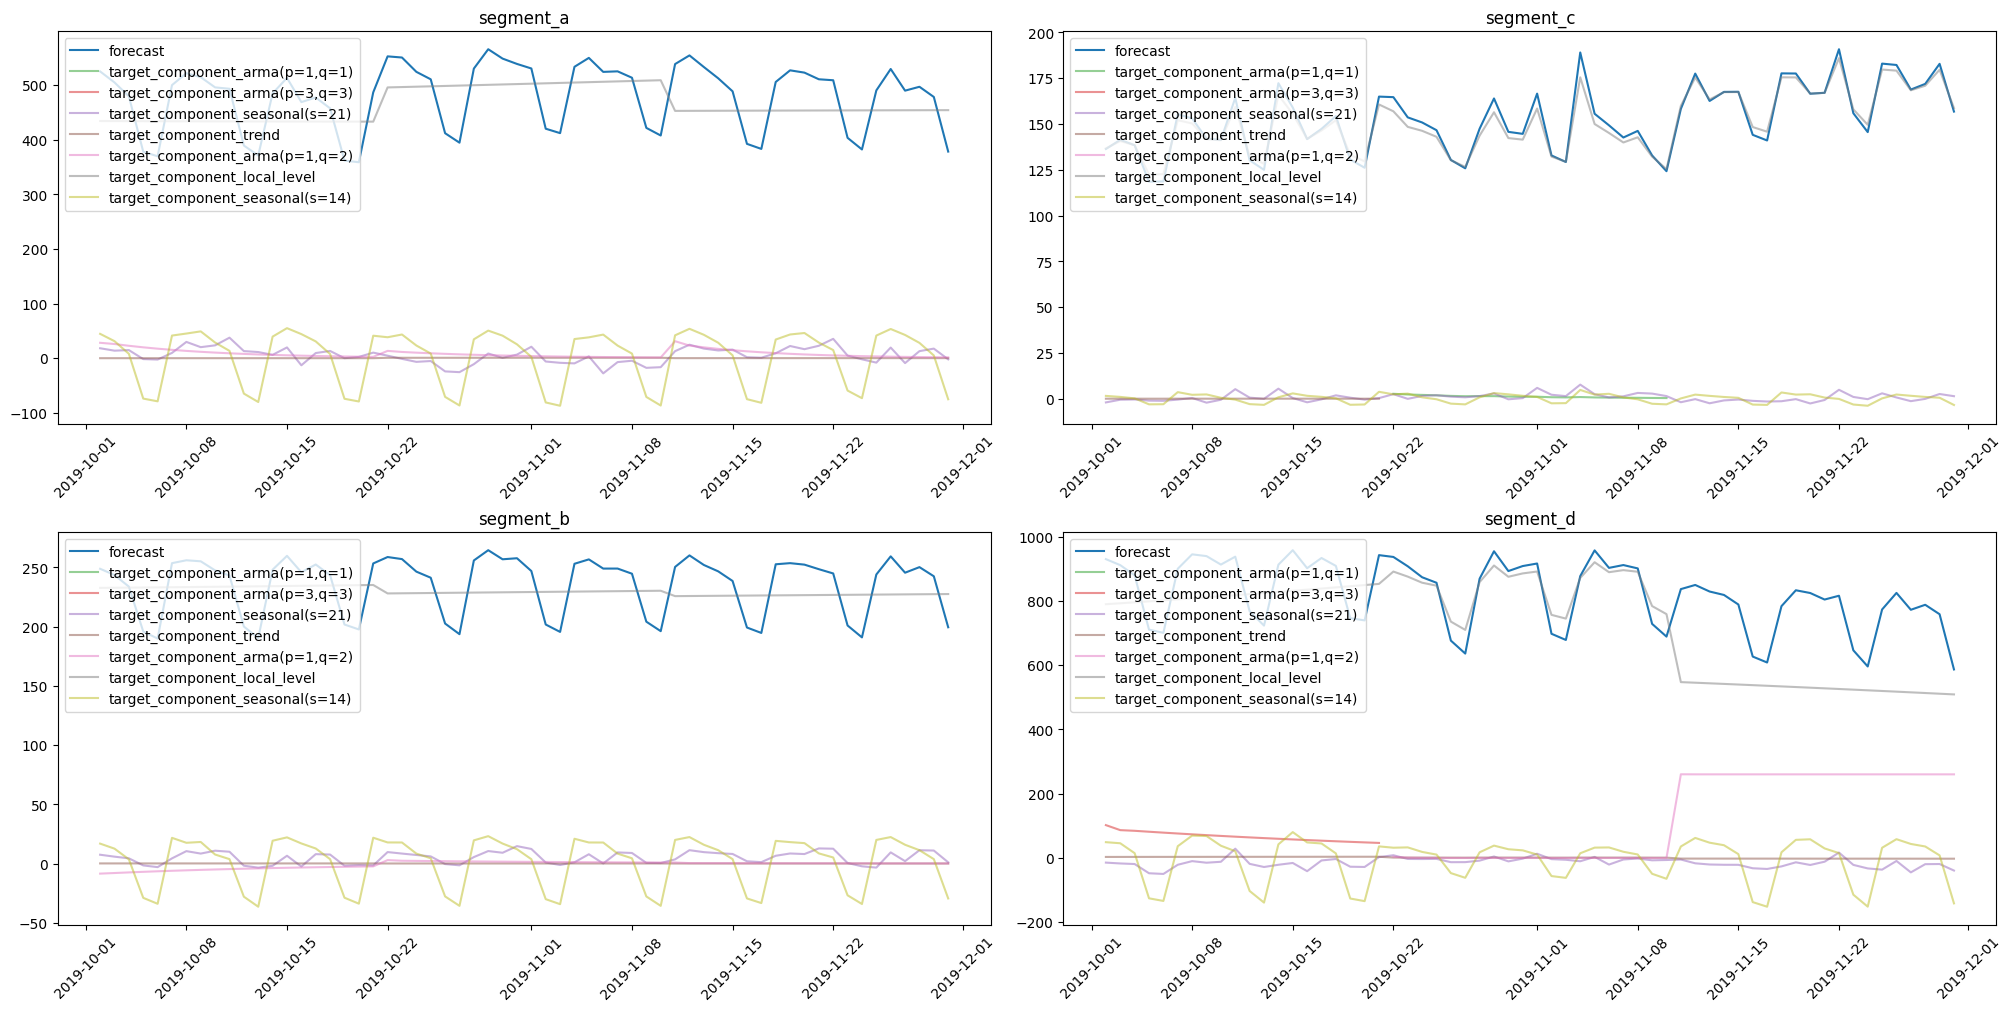

In [21]:
plot_forecast_decomposition(forecast_ts=TSDataset(df=forecast_df, freq="D"), mode="joint", columns_num=2)

Here we obtained components for trend, local level, seasonality, and ARMA errors. Note that each seasonality
period is represented by a separate component. Such a form of decomposition helps to find causality with
seasonal effects in the original data. Results show that almost all seasonal fluctuations come from
seasonality in period 14.

## 2. Accessing target components <a class="anchor" id="chapter2"></a>
This section shows how one can manipulate forecast components using the TSDataset` interface.

Let's populate our data with lag features and fit the `CatBoostPerSegmentModel`. We will use this setup
to estimate forecast with additive components.

In [22]:
ts_with_lags = deepcopy(ts)
ts_with_lags.fit_transform(transforms=transforms)

model = CatBoostPerSegmentModel()
model.fit(ts=ts_with_lags);

Now we can estimate forecasts with forecast decomposition. To do so, `return_components` should be set to `True`,
when calling `forecast` or `predict`.

In [23]:
forecast = model.forecast(ts=ts_with_lags, return_components=True)
forecast

segment    segment_a                                                 \
feature       lag_21 lag_28 lag_35 lag_42 lag_49 lag_56      target   
timestamp                                                             
2019-01-01       NaN    NaN    NaN    NaN    NaN    NaN  368.960244   
2019-01-02       NaN    NaN    NaN    NaN    NaN    NaN  368.960244   
2019-01-03       NaN    NaN    NaN    NaN    NaN    NaN  368.960244   
2019-01-04       NaN    NaN    NaN    NaN    NaN    NaN  368.960244   
2019-01-05       NaN    NaN    NaN    NaN    NaN    NaN  368.960244   
...              ...    ...    ...    ...    ...    ...         ...   
2019-11-26     510.0  502.0  532.0  582.0  528.0  558.0  587.562771   
2019-11-27     501.0  497.0  515.0  559.0  550.0  516.0  602.751237   
2019-11-28     525.0  501.0  520.0  543.0  547.0  489.0  556.927263   
2019-11-29     534.0  480.0  511.0  523.0  544.0  471.0  568.569172   
2019-11-30     430.0  384.0  502.0  422.0  423.0  371.0  499.505858   

segment                                                     \
feature    target_component_lag_21 target_component_lag_28   
timestamp                                                    
2019-01-01               52.677657               45.848608   
2019-01-02               52.677657               45.848608   
2019-01-03               52.677657               45.848608   
2019-01-04               52.677657               45.848608   
2019-01-05               52.677657               45.848608   
...                            ...                     ...   
2019-11-26               92.622123               93.063689   
2019-11-27               93.055945               93.196738   
2019-11-28               89.108979               94.226170   
2019-11-29               96.026571               92.935954   
2019-11-30               81.304877               65.772926   

segment                             ... segment_d                             \
feature    target_component_lag_35  ...    lag_42 lag_49  lag_56      target   
timestamp                           ...                                        
2019-01-01               59.139714  ...       NaN    NaN     NaN  440.294693   
2019-01-02               59.139714  ...       NaN    NaN     NaN  440.294693   
2019-01-03               59.139714  ...       NaN    NaN     NaN  440.294693   
2019-01-04               59.139714  ...       NaN    NaN     NaN  440.294693   
2019-01-05               59.139714  ...       NaN    NaN     NaN  440.294693   
...                            ...  ...       ...    ...     ...         ...   
2019-11-26              102.406833  ...     931.0  879.0  1037.0  937.554113   
2019-11-27               98.617847  ...     897.0  886.0   969.0  941.766157   
2019-11-28               90.372332  ...     882.0  934.0   929.0  894.837318   
2019-11-29               88.949103  ...     843.0  885.0   874.0  899.518552   
2019-11-30              113.489016  ...     652.0  672.0   664.0  720.744048   

segment                                                     \
feature    target_component_lag_21 target_component_lag_28   
timestamp                                                    
2019-01-01               58.143024               43.773274   
2019-01-02               58.143024               43.773274   
2019-01-03               58.143024               43.773274   
2019-01-04               58.143024               43.773274   
2019-01-05               58.143024               43.773274   
...                            ...                     ...   
2019-11-26              186.185095              152.507876   
2019-11-27              189.933535              153.970751   
2019-11-28              181.561275              154.268641   
2019-11-29              178.867363              163.091693   
2019-11-30              108.165250              129.946841   

segment                                                     \
feature    target_component_lag_35 target_component_lag_42   
timestamp             

Note that we have additional columns prefixed with `target_component_`. These are individual effects
that contributed to the overall forecast.

One can obtain forecast components separately from other forecast data using `get_target_components`.

In [24]:
forecast.get_target_components()

segment                  segment_a                          \
feature    target_component_lag_21 target_component_lag_28   
timestamp                                                    
2019-01-01               52.677657               45.848608   
2019-01-02               52.677657               45.848608   
2019-01-03               52.677657               45.848608   
2019-01-04               52.677657               45.848608   
2019-01-05               52.677657               45.848608   
...                            ...                     ...   
2019-11-26               92.622123               93.063689   
2019-11-27               93.055945               93.196738   
2019-11-28               89.108979               94.226170   
2019-11-29               96.026571               92.935954   
2019-11-30               81.304877               65.772926   

segment                                                     \
feature    target_component_lag_35 target_component_lag_42   
timestamp                                                    
2019-01-01               59.139714               69.745969   
2019-01-02               59.139714               69.745969   
2019-01-03               59.139714               69.745969   
2019-01-04               59.139714               69.745969   
2019-01-05               59.139714               69.745969   
...                            ...                     ...   
2019-11-26              102.406833              115.592269   
2019-11-27               98.617847              104.375155   
2019-11-28               90.372332               88.756972   
2019-11-29               88.949103               89.018761   
2019-11-30              113.489016               86.668521   

segment                                                     \
feature    target_component_lag_49 target_component_lag_56   
timestamp                                                    
2019-01-01               69.187315               72.360981   
2019-01-02               69.187315               72.360981   
2019-01-03               69.187315               72.360981   
2019-01-04               69.187315               72.360981   
2019-01-05               69.187315               72.360981   
...                            ...                     ...   
2019-11-26               74.912398              108.965459   
2019-11-27              114.013395               99.492157   
2019-11-28              112.596508               81.866302   
2019-11-29              117.011601               84.627183   
2019-11-30               78.966691               73.303827   

segment                  segment_b                          \
feature    target_component_lag_21 target_component_lag_28   
timestamp                                                    
2019-01-01               29.190551               23.342434   
2019-01-02               29.190551               23.342434   
2019-01-03               29.190551               23.342434   
2019-01-04               29.190551               23.342434   
2019-01-05               29.190551               23.342434   
...                            ...                     ...   
2019-11-26               39.646473               41.938191   
2019-11-27               44.803978               42.526073   
2019-11-28               43.636738               39.279155   
2019-11-29               41.949065               38.703364   
2019-11-30               38.118666               33.999578   

segment                                                     ...  \
feature    target_component_lag_35 target_component_lag_42  ...   
timestamp                                                   ...   
2019-01-01               27.285093               28.338942  ...   
2019-01-02               27.285093               28.338942  ...   
2019-01-03               27.285093               28.338942  ...   
2019-01-04               27.285093               28.338942  ...   
2019-01-05               27.285093               28.338

There is a possibility to remove components. It can be achieved using `drop_target_components`.
This function will remove components inplace. We can ensure that our forecast dataset no longer has
any components by using the `target_components_names` property.

In [25]:
components = forecast.get_target_components()
forecast.drop_target_components()
forecast.target_components_names

()

There is a possibility to attach components to the forecast dataset as well.
The main constraint on components is that, being attached, they should sum up to the target at each timestamp.

In [26]:
forecast.add_target_components(components)
forecast.target_components_names

('target_component_lag_21',
 'target_component_lag_28',
 'target_component_lag_35',
 'target_component_lag_42',
 'target_component_lag_49',
 'target_component_lag_56')

## 3. Components relevance <a class="anchor" id="chapter3"></a>
This section shows how component relevance could be estimated.

There are two types of relevance estimation in the ETNA library
* statistical, based on `tsfresh` (`StatisticsRelevanceTable`)
* model based (`ModelRelevanceTable`)

In [27]:
from etna.analysis import plot_feature_relevance
from etna.analysis import StatisticsRelevanceTable
from etna.analysis import ModelRelevanceTable
from sklearn.ensemble import RandomForestRegressor

In [28]:
target_with_components = forecast.df.drop(columns=forecast.regressors, level="feature")
target_with_components = TSDataset(df=target_with_components, freq=forecast.freq)

Let's estimate component relevance using a statistical approach. Results can be shown with the help of the `plot_feature_relevance` function.

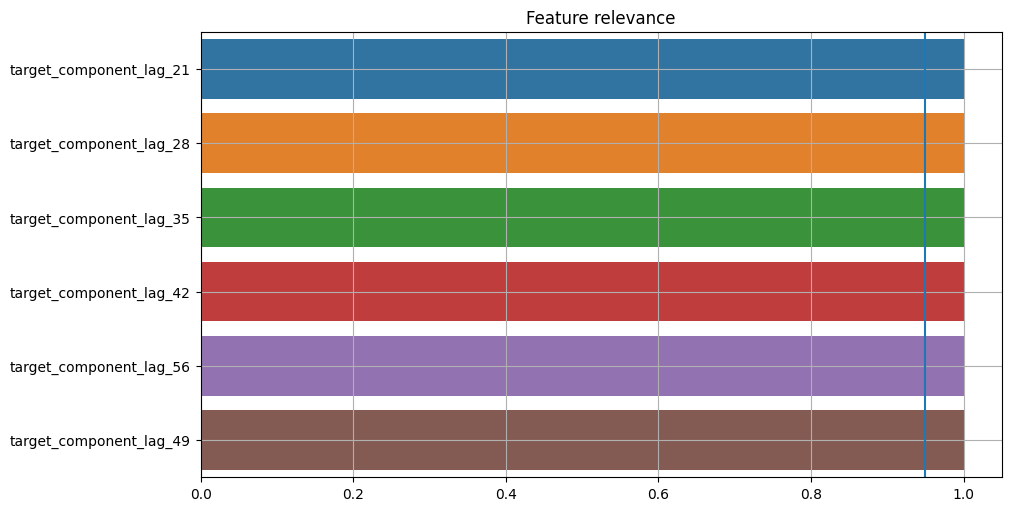

In [29]:
plot_feature_relevance(ts=target_with_components, relevance_table=StatisticsRelevanceTable())

We can use a separate estimator that is able to provide feature relevance to estimate target components relevance.
In this case, we can use `RandomForestRegressor`.

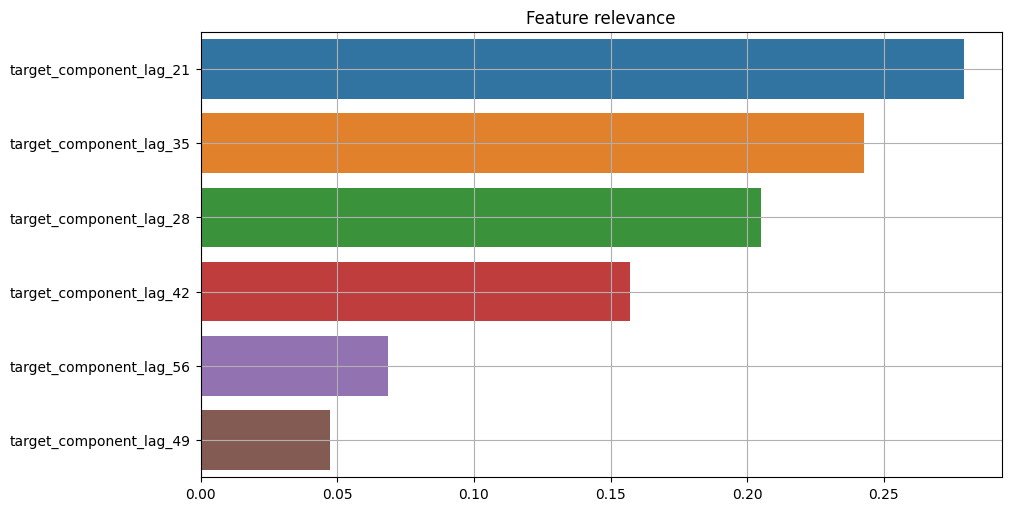

In [30]:
plot_feature_relevance(
    ts=target_with_components,
    relevance_table=ModelRelevanceTable(),
    relevance_params={"model": RandomForestRegressor()},
)